#Introduction to the task

The task consists in taking in input a single image of size 32x32 which is composed by the sum of two images (input_img = img1 + img2) and decompose it in its two components.
My network takes in input the input_img and returns a single image of size 32x64 that has the two components (hat_img1 and hat_img2) side by side. 

#Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import BatchNormalization, Activation, Conv2D, Input, Conv2DTranspose, concatenate, Dropout, Concatenate
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras import callbacks

#Speed up the training 
keras.mixed_precision.set_global_policy("mixed_float16")

In [ ]:
def plot_history(history, start_epoch):

  history_dict = history.history
  history_dict.keys()
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs=range(1,len(loss_values)+1)
  plt.plot(epochs[start_epoch:],loss_values[start_epoch:],label='Training loss')
  plt.plot(epochs[start_epoch:],val_loss_values[start_epoch:],label='Validation loss')
  plt.title("train and validation loss")
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

def plt_img(ax, title, img):
  ax.imshow(img,cmap='gray', interpolation='nearest')
  ax.set_title(title)

#The dataset

##Create the dataset

The dataset is composed by copules (x, y) where x is a 32x32 image composed by the sum of two initial images (img1 and img2), one taken from the mnist dataset, and one taken from the fashion_mnist dataset. y is a 32x64 image composed by img1 and img2 side by side.

I decided to split the given train set in training and validation to check the performance of the network during the training. This choice is very compatible with the proposed task because, even after the split, the size of the training set is very huge ($50.000^2$ samples).

In [ ]:
#load the datasets
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#splitting the train set into train and validation sets
mnist_x_val = mnist_x_train[:10000]
mnist_x_train = mnist_x_train[10000:]
fashion_mnist_x_val = fashion_mnist_x_train[:10000]
fashion_mnist_x_train = fashion_mnist_x_train[10000:]

4422102/4422102 [==============================] - 0s 0us/step


##Exploring the dataset
In order to better understand the task, I plotted some images from the training set. As written before, we have 32x32 images as input (left columns) and a 32x64 images as ground truth (right column).

I observed that all the images are composed by a number overlapped to a fashion item (a pullover, a t-shirt, a dress or a shoe). Even though both images are in gray-scale, the number is always recognizable in the composed images because it is colored mostly in white. Furthermore, the two elements in the training pictures are normalized dividing the sum of the two images by 2. In this way even if two white pixels of the two images are overlapped, we reaches the correct max values of 1.

In [ ]:
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
mnist_x_val = np.pad(mnist_x_val,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.

def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [ ]:
img_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,32)
x, y = next(img_generator)

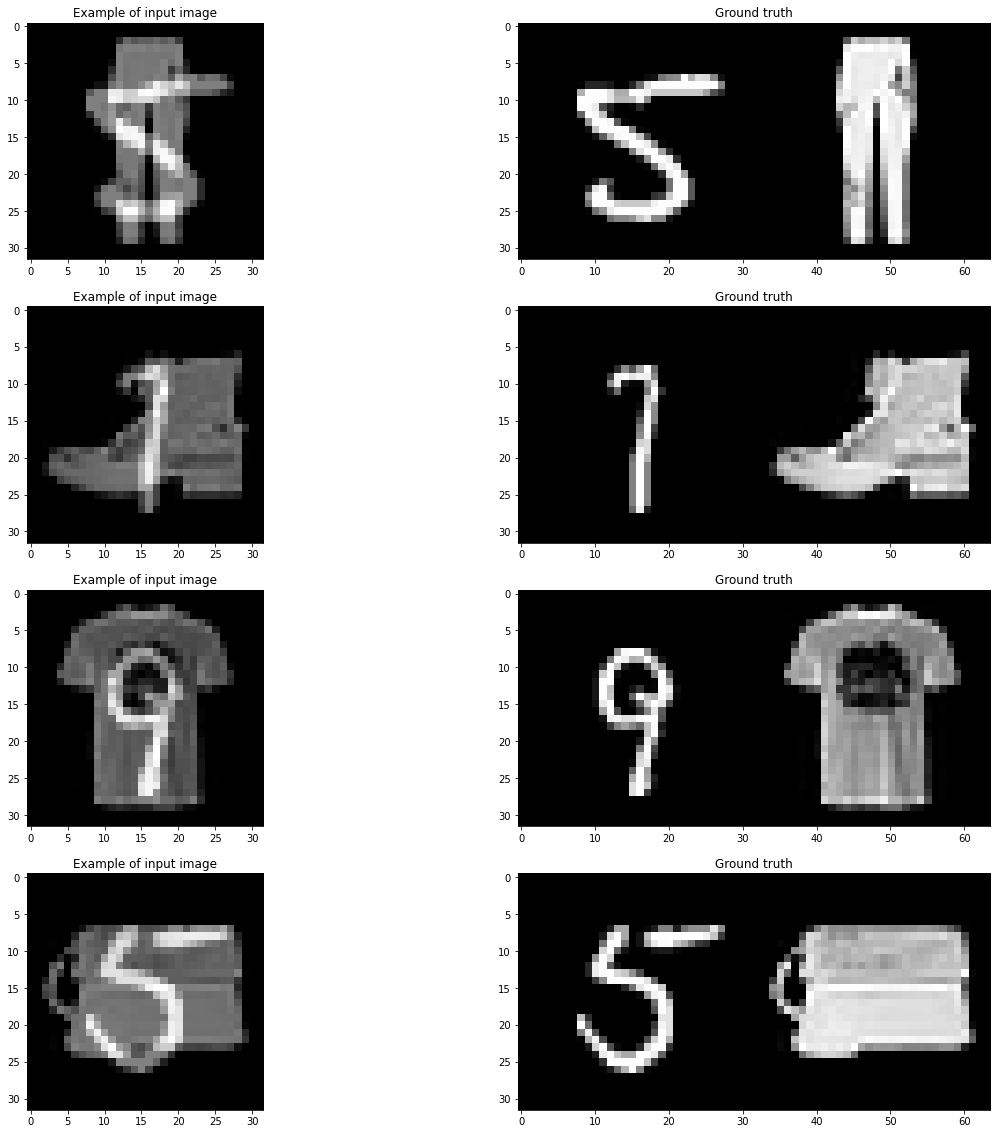

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 2, figsize=(20, 20))
plt_img(ax1[0], 'Example of input image', x[0])
plt_img(ax1[1], 'Ground truth', y[0])
plt_img(ax2[0], 'Example of input image', x[1])
plt_img(ax2[1], 'Ground truth', y[1])
plt_img(ax3[0], 'Example of input image', x[2])
plt_img(ax3[1], 'Ground truth', y[2])
plt_img(ax4[0], 'Example of input image', x[3])
plt_img(ax4[1], 'Ground truth', y[3])

#The model


Taking inspiration by [this](https://arxiv.org/pdf/1505.04597.pdf) paper I tried to build a Unet to achieve the proposed task.

The network has two main parts:
* contracting part;
* expansive part.

###Contracting part
The first part of the network (after taking in input a 32x32 image) has 3 blocks and each of them has the following structure:
* 4 *Conv2D* (padded) layers with doubling number of filters (starting from 64 to 256);
* Each *Conv2D* is followed by a *BatchNormalization* layer and then by an *Activation* layer with a *ReLU function*;
* After the 4 *Conv2D* layers there is and additional one but with the parameter *strides=(2,2)* which has the purpose to downsample. This additional layer is not present in the third block;
* One *Dropout* layer at the end of the block (the dropout value is 0.15).

###Expansive part
This part of the network has the task of upsample the image and it does this work with two blocks which have the following stricture:
* a *Conv2DTranspose* layer that upsample the images;
* a *concatenate* layer after the *Conv2DTranspose* one which concatenates the output of the *Conv2DTranspose* with the correspondingly cropped
feature map from the contracting path;
* 4 *Conv2D* layers with 128 filters in the first block and 64 in the second one
* Each layer (except the concatenate ones) is followed by a *BatchNormalization* and by a *ReLU activation function*. 

About the *BatchNormalization*, I chose to use it because it allows the model to see different samples more similar and this helps the model to generalize better on new data. Furthermore, I put the *Activation* after the normalization because it centers the input on zero and the ReLU uses zero as pivot for keeping or dropping activated channels, so doing normalization before the activation maximizes the utilization of the ReLU.(source: *Deep learning with python, second edition*)

##Output
The output of the last deconvulation block goes in two *Conv2D* layers which have *filters* equal to 1 (because we want gray scale images as output) and *kernel_size* equal to 1. This two layers produce the outputs output_1 and output_2 respectively which are the 32x32 images, then a *Concatenate* layer concatenates this two outputs in the final 32x64 output image.

In [ ]:

def my_model(input_shape=None):
    drop_out = 0.15
    img_input = Input(shape=input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_1a = Conv2D(64, (3, 3), padding='same', name='block1_conv4')(x)
    x_1a = BatchNormalization()(x_1a)
    x_1a = Activation('relu')(x_1a)
    x = Conv2D(64,(2, 2), strides=(2, 2), name='block1_conv_strides')(x_1a)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_out)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x_2a = Conv2D(128, (3, 3), padding='same', name='block2_conv4')(x)
    x_2a = BatchNormalization()(x_2a)
    x_2a = Activation('relu')(x_2a)
    x = Conv2D(128,(2, 2), strides=(2, 2), name='block2_pool_strides')(x_2a)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_out)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_out)(x)
    
    
    # Deconv Block 1
    x_2b = Conv2DTranspose(128, (2, 2), strides=(2, 2), input_shape=(None,23, 23, 1), name='dblock1_deconv1', padding = 'same')(x)
    x_2b = BatchNormalization()(x_2b)
    x_2b = Activation('relu')(x_2b)
    x = concatenate([x_2a, x_2b])
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='dblock1_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='dblock1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='dblock1_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='dblock1_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Deconv Block 2
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock2_deconv', padding = 'same')(x)
    x_1b = BatchNormalization()(x_1b)
    x_1b = Activation('relu')(x_1b)
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))
    x = Conv2D(64, (3, 3), padding='same', name='dblock2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3),padding='same', name='dblock2_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='dblock2_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='dblock2_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #changing the dtype to easily plot the predicted images
    output_1 = Conv2D(1, 1, activation='relu', padding='same', dtype='float32')(x)
    output_2 = Conv2D(1, 1, activation='relu', padding='same', dtype='float32')(x)
    output = Concatenate(axis=2,dtype='float32')([output_1,output_2])

    inputs = img_input
    
    model = Model(img_input, output, name='EdoardoProcino_Unet')

    return model

model = my_model(input_shape=(32,32,1))


As optimizer I chose Adam with an initial learning rate equal to 0.0015, while as loss function I chose the Mean Squared Error since the aim of the task is to minimize it. 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0015),loss='mse')

The next two cells show the network graphically and by the summary.

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
model.summary()

#Training the network
I fitted the network with the train_generator (as training set) and val_generator (as validation set) to allow the model to train itself seeing always new training saples (this is possible due to the very big dimension of the training space).

##Hyperparameters
After a long tuning the final configuration is the following one:
* I used three caalbacks:
  * *EarlyStopping* to stop the network during the training if the      validation loss does not improve anymore for 10 epochs;
  * *ModelCheckpoint* with the parameter *save_only_best=True* to save the model when it is considered the "best" according to the monitored metric (in this case the val_loss);
  * *ReduceLROnPlateau* to decrease the learning rate multiplying it by 0.5 if for 3 epochs the monitored metric does not improve.

* The epochs are 40 because with this number the vall_loss stops to decrease and it is very very close to the train loss (with some fluctations, see the graphs in the cell after the training one);

* The batch size of the training is $2^5$ because with a small number the uploads of the model weights are more precise;

* The *step_per_epoch* are 10.000 because with a such large number I allow the network to see a lot of training examples (320.000 each epoch) and the validation loss is calculated less times than using, for example, more epochs and less step_per_epoch. This is useful because the callback *ReduceLROnPlateau* become more effective since it sees the vall_loss to trigger itself;

* The validation batch size is $2^5$ and the *validation_steps* is only 50 to train faster.

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,2**5)
val_generator = datagenerator(mnist_x_val,fashion_mnist_x_val,2**5)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=0,monitor='val_loss'),
    keras.callbacks.ModelCheckpoint(
        filepath='exam.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001, min_delta=0.00001)
]

history = model.fit(
    x = train_generator,
    epochs=40,
    callbacks=callbacks,
    validation_data= val_generator,
    steps_per_epoch=10000,
    validation_steps=50
)


From the two plots (the former shows all the epochs, while the latter shows only the last 20 epochs) we can see that the validation loss goes down following the training loss except for some very low fluctuations.
So the model is well fitted (there is neither underfitting nor overfitting).

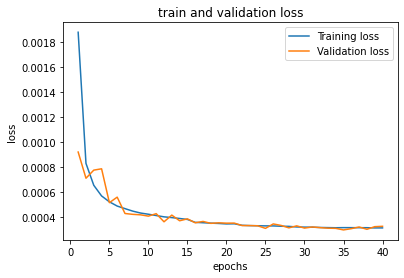

In [ ]:
plot_history(history,0)

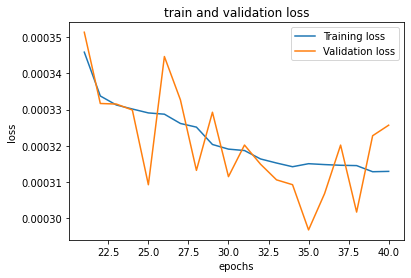

In [ ]:
plot_history(history,20)

#Results

In [ ]:
#Thanks to the ModelCheckpoint callback I take the weights of the best model achieved during the training
model.load_weights('exam.keras')

The Mean Squared Error achieved on the test set is very low and very close to the validation loss.
I computed the mse 10 times on different test sets (passing to the model.evaluate the test_generator with 32 batch size and 625 steps, so 20.000 samples) and I acchieved the following results:
##Best result: 0.0003125
####Mean of MSEs: 0.003160
####standard deviation: 1.8099e-06

In [ ]:
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,32)
mses=[]
for i in range(0,10):
  mses.append(model.evaluate(test_generator, steps=625))
print('Mean mse: ',np.mean(mses))
print('Standard deviation: ',np.std(mses))
print('Min mse: ',np.min(mses))

625/625 [==============================] - 9s 14ms/step - loss: 3.1461e-04
Mean mse:  0.0003160843189107254
Standard deviation:  1.8099865420044966e-06
Min mse:  0.0003125293005723506


In this last cell I printed 4 sets of images. Each set contains the insput image, the original two image that we want to ricreate (the ground truth) and the corresponding generated image. It is clear that the network works very well since the ground truth images and the generated ones are almost indistinguishable from an human eye.

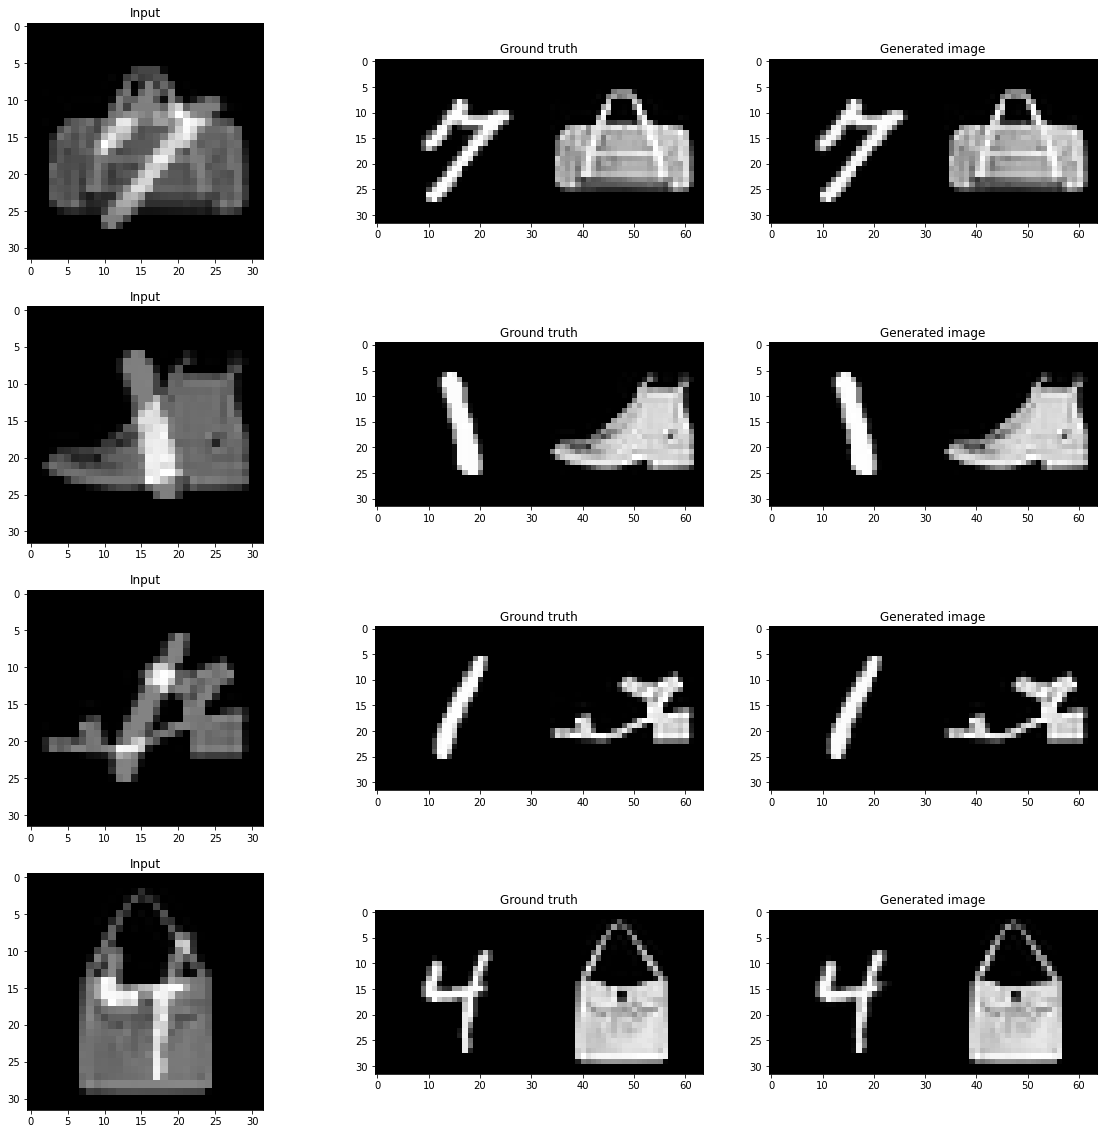

In [ ]:
x_test, y_test = next(test_generator)
predictions = model.predict(x_test)
predictions = predictions.reshape((32,32,64))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 3, figsize=(20, 20))
plt_img(ax1[0], 'Input', x_test[0])
plt_img(ax1[1], 'Ground truth', y_test[0])
plt_img(ax1[2], 'Generated image', predictions[0])

plt_img(ax2[0], 'Input', x_test[1])
plt_img(ax2[1], 'Ground truth', y_test[1])
plt_img(ax2[2], 'Generated image', predictions[1])

plt_img(ax3[0], 'Input', x_test[2])
plt_img(ax3[1], 'Ground truth', y_test[2])
plt_img(ax3[2], 'Generated image', predictions[2])

plt_img(ax4[0], 'Input', x_test[3])
plt_img(ax4[1], 'Ground truth', y_test[3])
plt_img(ax4[2], 'Generated image', predictions[3])

In [ ]:
#saving the model weights
model.save_weights('edoardo_procino_weights.h5')